In [914]:
# imports - importing only the libraries that are allowed😅
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import sys
import seaborn as sns

# extra imports - only for preprocessing, not for training
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# Implementation of fully connected feed-forward neural network with backpropagation from scratch for the task of classification on the given dataset.

---



In [948]:
class FNN:
  def __init__(self, layers, activations, init='zeros', seed=1):
    '''
    '''
    assert(layers!=None)
    assert(activations!=None)
    assert(len(layers)==len(activations))
    np.random.seed(seed)
    self.layers = layers
    self.activations = activations
    self.weights, self.biases = self.initialise(init, len(self.layers))
    self.loss = None
    self.optimiser = None
    self.lr = None
    self.metrics = None
    self.compiled = False
    self.Zcache = None
    self.Acache = None
    self.history = None

  def initialise(self, init, len_layers):
    '''
    type: zeros, ones, random_normal, random_uniform, glorot_normal, glorot_uniform
    '''
    w = []
    b = []
    if init == 'zeros':
      for i in range(1, len_layers):
        w.append(np.zeros(shape=(self.layers[i-1], self.layers[i])))
        b.append(np.zeros(shape=(self.layers[i], 1)))
    if init == 'ones':
      for i in range(1, len_layers):
        w.append(np.ones(shape=(self.layers[i-1], self.layers[i])))
        b.append(np.ones(shape=(self.layers[i], 1)))
    if init == 'random_uniform':
      for i in range(1, len_layers):
        w.append(np.random.rand(self.layers[i-1], self.layers[i]))
        b.append(np.random.rand(self.layers[i], 1))
    if init == 'random_normal':
      for i in range(1, len_layers):
        w.append(np.random.randn(self.layers[i-1], self.layers[i]))
        b.append(np.random.randn(self.layers[i], 1))
    return np.asarray(w, dtype=object), np.asarray(b, dtype=object)
  
  def activate(self, act, acu):
    '''
    act: linear, tanh, sigmoid, softmax, relu, leakyrelu
    '''
    if act == 'tanh':
      return self.tanh(acu)
    if act == 'sigmoid':
      return self.sigmoid(acu)
    if act == 'softmax':
      return self.softmax(acu)
    if act == 'relu':
      return self.relu(acu)

  @staticmethod
  def tanh(v):
    '''
    '''
    assert(v.shape[1]==1)
    v = np.asarray(v, dtype='float64')
    return np.tanh(v)

  def der_tanh(self, v):
    '''
    '''
    assert(v.shape[1]==1)
    v = np.asarray(v, dtype='float64')
    return 1 - np.square(self.tanh(v))

  @staticmethod
  def sigmoid(v):
    '''
    '''
    assert(v.shape[1]==1)
    v = np.asarray(v, dtype='float64')
    return 1/(1 + np.exp(v))
  
  def der_sigmoid(self, v):
    '''
    '''
    assert(v.shape[1]==1)
    v = np.asarray(v, dtype='float64')
    return self.sigmoid(v) * (1 - self.sigmoid(v))

  @staticmethod
  def softmax(v):
    '''
    '''
    assert(v.shape[1]==1)
    v = np.asarray(v, dtype='float64')
    ex = np.exp(v - np.max(v))
    return ex/np.sum(ex)
  
  def der_softmax(self, v):
    '''
    '''
    assert(v.shape[1]==1)
    v = np.asarray(v, dtype='float64')
    return self.softmax(v) * (1 - self.softmax(v))

  @staticmethod
  def relu(v):
    assert(v.shape[1]==1)
    v = np.asarray(v, dtype='float64')
    return np.maximum(v, 0)

  def der_relu(self, v):
    assert(v.shape[1]==1)
    v = np.asarray(v, dtype='float64')
    return (v>0)

  @staticmethod
  def leakyrelu():
    pass

  def graph(self):
    pass
  
  def forward(self, x):
    '''
    each node has following semantics in forward pass, activation(wTx + b)
    Note: input must have dimensions, (features x 1)
    '''
    acu = x
    self.Zcache = []
    self.Acache = []
    self.Acache.append(x)
    for i in range(1, len(self.layers)):
      acu = np.matmul(np.transpose(self.weights[i-1]), acu)
      acu += self.biases[i-1]
      self.Zcache.append(acu)
      acu = self.activate(self.activations[i-1], acu)
      self.Acache.append(acu)
    self.Zcache = np.asarray(self.Zcache, dtype=object)
    self.Acache = np.asarray(self.Acache, dtype=object)
    return acu

  def lossF(self, ypred, ytrue):
    '''
    loss: mse, categorical_crossentropy, binary_crossentropy, kldivergence
    '''
    if self.loss == 'mse':
      return np.sum(np.square(np.subtract(ytrue,ypred)))
    if self.loss == 'categorical_crossentropy':
      pass

  def der_A_wrt_Z(self, act, Z):
    if act == 'softmax':
      return self.der_softmax(Z)
    if act == 'sigmoid':
      return self.der_sigmoid(Z)
    if act == 'linear':
      return 1
    if act == 'tanh':
      return self.der_tanh(Z)
    if act == 'relu':
      return self.der_relu(Z)

  def der_loss_wrt_A(self, ytrue, ypred):
    if self.loss == 'mse':
        return (2 * (ypred - ytrue))
    if self.loss == 'categorical_crossentropy':
      pass

  def backward(self, ytrue, ypred):
    gradw = []
    gradb = []
    dZ = self.der_loss_wrt_A(ytrue, ypred) * self.der_A_wrt_Z(self.activations[-1], self.Zcache[-1])
    for l in range(len(self.layers)-1, 1, -1):
      dW = np.matmul(self.Acache[l-1], np.transpose(dZ))
      db = dZ
      gradw.append(dW)
      gradb.append(db)
      dZ = np.matmul(self.weights[l-1], dZ)* self.der_A_wrt_Z(self.activations[l-2], self.Zcache[l-2])
    dW = np.matmul(self.Acache[0], np.transpose(dZ))
    db = dZ
    gradw.append(dW)
    gradb.append(db)
    gradw.reverse()
    gradb.reverse()
    return np.asarray(gradw, dtype=object), np.asarray(gradb, dtype=object)

  def compile(self, optimiser='gd', loss='mse', metrics=None, lr=0.01):
    '''
    optimiser: gd, sgd, adam
    '''
    self.loss = loss
    self.optimiser = optimiser
    self.lr = lr
    self.metrics = metrics
    self.compiled = True

  def train(self, X, Y, valX, valY, epochs=1, shuffle=False):
    '''
    '''
    assert(len(X)==len(Y))
    assert(epochs>0)
    assert(self.compiled==True)

    self.history = {'loss': [], 'acc': [], 'f1': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
    exsize = len(X)
    vexsize = len(valX)
    indices = np.arange(exsize)
    for e in range(epochs):
      if shuffle==True:
        self.rnd.shuffle(indices)

      for t in range(exsize):
        idx = indices[t]
        x = X[idx].reshape(X[idx].shape[0], 1)
        y = Y[idx]
        assert(x.shape[1]==1)
        assert(y.shape[1]==1)

        #forward pass, for finding output
        acu = self.forward(x)

        #backward pass and computing gradients
        gradw, gradb = self.backward(y, acu)

        #updating weights
        self.update_weights(gradw, gradb)

      #forward pass and computing loss and accuracy
      als = 0
      ypred = []
      for t in range(exsize):
        idx = indices[t]
        x = X[idx].reshape(X[idx].shape[0], 1)
        y = Y[idx]
        acu = self.forward(x)
        als += self.lossF(acu, y)
        ypred.append(acu)
      als/=exsize
      self.history['loss'].append(als)
      ypred = np.asarray(ypred, dtype=object)

      #forward pass and computing validation loss and accuracy
      vls = 0
      vypred = []
      for t in range(vexsize):
        vx = valX[t].reshape(valX[t].shape[0], 1)
        vy = valY[t]
        vacu = self.forward(vx)
        vls += self.lossF(vacu, vy)
        vypred.append(vacu)
      vls/=vexsize
      self.history['val_loss'].append(vls)
      vypred = np.asarray(vypred, dtype=object)      

      self.pretty_print_epoch(e, als, ypred, Y, exsize, vls, vypred, valY, vexsize)
    
    print("Training Ended\n")

  def pretty_print_epoch(self, e, als, ypred, Y, exsize, vls, vypred, valY, vexsize):
    acc, f1 = self.accuracy_and_f1score(Y, ypred, exsize)
    vacc, vf1 = self.accuracy_and_f1score(valY, vypred, vexsize)
    self.history['acc'].append(acc)
    self.history['f1'].append(f1)
    self.history['val_acc'].append(vacc)
    self.history['val_f1'].append(vf1)
    print("epoch: %d | loss: %.4f | accuracy: %.4f | f1 score: %.4f | val loss: %.4f | val accuracy: %0.4f | val f1 score: %.4f" % (e, als, acc, f1, vls, vacc, vf1))

  def update_weights(self, gradw, gradb):
    '''
    '''
    assert(self.weights.shape == gradw.shape)
    assert(self.biases.shape == gradb.shape)
    self.weights -= self.lr * gradw
    self.biases -= self.lr * gradb

  def predict(self, UX):
    Uexsize = len(UX)
    Uypred = []
    for t in range(Uexsize):
      Ux = UX[t].reshape(UX[t].shape[0], 1)
      Uacu = self.forward(Ux)
      Uypred.append(np.argmax(Uacu))
    Uypred = np.asarray(Uypred)
    return Uypred


  def accuracy(self, ytrue, ypred, exsize):
    '''
    accuracy: correctly classified samples/total samples
    '''
    assert(ytrue.shape==ypred.shape)
    sum = 0
    for i in range(exsize):
      if np.argmax(ytrue[i]) == np.argmax(ypred[i]):
        sum+=1
    sum/=exsize
    return sum

  def accuracy_and_f1score(self, ytrue, ypred, exsize):
    yt = []
    yp = []
    for i in range(exsize):
      yt.append(np.argmax(ytrue[i]))
      yp.append(np.argmax(ypred[i]))
    return accuracy_score(yt, yp), f1_score(yt, yp, average='weighted')
      

# Data Loading and Proprocessing

---



In [974]:
traindf = pd.read_csv('/content/data_train.csv')
testdf = pd.read_csv('/content/data_test.csv')

In [975]:
traindf.head()

,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU_ID,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,1,2020-04-29,2020-05-05,2020-05-05,2020-05-03,40s,FEMALE,CC,Resolved,NaN,2253.0,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
1,2,2020-03-29,2020-04-11,2020-04-15,2020-04-08,50s,FEMALE,CC,Fatal,NaN,2253.0,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
2,3,2020-03-29,2020-04-07,2020-04-07,2020-04-06,40s,FEMALE,CC,Resolved,NaN,2253.0,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
3,4,2020-06-15,2020-06-16,2020-06-16,2020-06-15,30s,FEMALE,UNSPECIFIED EPI LINK,Resolved,NaN,2253.0,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
4,5,2020-04-17,2020-04-28,2020-04-28,2020-04-27,50s,FEMALE,CC,Resolved,NaN,2253.0,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893


## Dropping unwanted columns

In [976]:
traindf = traindf.drop("Row_ID", axis=1)
# traindf = traindf.drop("Accurate_Episode_Date", axis=1)
# traindf = traindf.drop("Case_Reported_Date", axis=1)
# traindf = traindf.drop("Test_Reported_Date", axis=1)
# traindf = traindf.drop("Specimen_Date", axis=1)
# traindf = traindf.drop("Age_Group", axis=1)
# traindf = traindf.drop("Client_Gender", axis=1)
# traindf = traindf.drop("Case_AcquisitionInfo", axis=1)
# traindf = traindf.drop("Outcome1", axis=1)
traindf = traindf.drop("Outbreak_Related", axis=1)
traindf = traindf.drop("Reporting_PHU_ID", axis=1)
# traindf = traindf.drop("Reporting_PHU", axis=1)
# traindf = traindf.drop("Reporting_PHU_Address", axis=1)
# traindf = traindf.drop("Reporting_PHU_City", axis=1)
# traindf = traindf.drop("Reporting_PHU_Postal_Code", axis=1)
# traindf = traindf.drop("Reporting_PHU_Website", axis=1)
# traindf = traindf.drop("Reporting_PHU_Latitude", axis=1)
# traindf = traindf.drop("Reporting_PHU_Longitude", axis=1)

In [977]:
# testdf = testdf.drop("Row_ID", axis=1)
# testdf = testdf.drop("Accurate_Episode_Date", axis=1)
# testdf = testdf.drop("Case_Reported_Date", axis=1)
# testdf = testdf.drop("Test_Reported_Date", axis=1)
# testdf = testdf.drop("Specimen_Date", axis=1)
# testdf = testdf.drop("Age_Group", axis=1)
# testdf = testdf.drop("Client_Gender", axis=1)
# testdf = testdf.drop("Case_AcquisitionInfo", axis=1)
testdf = testdf.drop("Outbreak_Related", axis=1)
testdf = testdf.drop("Reporting_PHU_ID", axis=1)
# testdf = testdf.drop("Reporting_PHU", axis=1)
# testdf = testdf.drop("Reporting_PHU_Address", axis=1)
# testdf = testdf.drop("Reporting_PHU_City", axis=1)
# testdf = testdf.drop("Reporting_PHU_Postal_Code", axis=1)
# testdf = testdf.drop("Reporting_PHU_Website", axis=1)
# testdf = testdf.drop("Reporting_PHU_Latitude", axis=1)
# testdf = testdf.drop("Reporting_PHU_Longitude", axis=1)

In [978]:
bool_series = pd.isnull(traindf["Test_Reported_Date"])
sum = 0
for i in range(len(traindf[bool_series])):
  sum+=1
print(sum)

7219


## Data missing values report and dropping them
- Test_Reported_Date: 7219 missing values
- Specimen_Date: 1273 missing values
- Age_Group: 1 missing value
- Client_Gender: 1 missing value
- Case_AcquisitionInfo: 1 missing value
- Outcome1: 1 missing value
- Outbreak_Related: 181361 missing values
- Reporting_PHU_ID: 1 missing value
- Reporting_PHU: 1 missing value
- Reporting_PHU_Address: 1 missing value
- Reporting_PHU_City: 1 missing value
- Reporting_PHU_Postal_Code: 1 missing value
- Reporting_PHU_Website: 1 missing value
- Reporting_PHU_Latitude: 1 missing value
- Reporting_PHU_Longitude: 1 missing value

Note: Row 228902 has all missing values for its columns, so dropping it.

In [979]:
traindf.drop([228902], inplace = True)

In [980]:
traindf["Test_Reported_Date"].fillna("Ambig", inplace = True)
traindf["Specimen_Date"].fillna("Ambig", inplace = True)

In [981]:
traindf.head()

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,2020-04-29,2020-05-05,2020-05-05,2020-05-03,40s,FEMALE,CC,Resolved,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
1,2020-03-29,2020-04-11,2020-04-15,2020-04-08,50s,FEMALE,CC,Fatal,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
2,2020-03-29,2020-04-07,2020-04-07,2020-04-06,40s,FEMALE,CC,Resolved,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
3,2020-06-15,2020-06-16,2020-06-16,2020-06-15,30s,FEMALE,UNSPECIFIED EPI LINK,Resolved,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
4,2020-04-17,2020-04-28,2020-04-28,2020-04-27,50s,FEMALE,CC,Resolved,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893


## Converting to categorical

In [982]:
# traindf['Row_ID'] = pd.factorize(traindf['Row_ID'])[0]
traindf['Accurate_Episode_Date'] = pd.factorize(traindf['Accurate_Episode_Date'])[0]
traindf['Case_Reported_Date'] = pd.factorize(traindf['Case_Reported_Date'])[0]
traindf['Test_Reported_Date'] = pd.factorize(traindf['Test_Reported_Date'])[0]
traindf['Specimen_Date'] = pd.factorize(traindf['Specimen_Date'])[0]
traindf['Age_Group'] = pd.factorize(traindf['Age_Group'])[0]
traindf['Client_Gender'] = pd.factorize(traindf['Client_Gender'])[0]
traindf['Case_AcquisitionInfo'] = pd.factorize(traindf['Case_AcquisitionInfo'])[0]
traindf['Outcome1'], labels = pd.factorize(traindf['Outcome1'])
# traindf['Outbreak_Related'] = pd.factorize(traindf['Outbreak_Related'])[0]
traindf['Reporting_PHU'] = pd.factorize(traindf['Reporting_PHU'])[0]
# traindf['Reporting_PHU_ID'] = pd.factorize(traindf['Reporting_PHU_ID'])[0]
traindf['Reporting_PHU_Address'] = pd.factorize(traindf['Reporting_PHU_Address'])[0]
traindf['Reporting_PHU_City'] = pd.factorize(traindf['Reporting_PHU_City'])[0]
traindf['Reporting_PHU_Postal_Code'] = pd.factorize(traindf['Reporting_PHU_Postal_Code'])[0]
traindf['Reporting_PHU_Website'] = pd.factorize(traindf['Reporting_PHU_Website'])[0]
traindf['Reporting_PHU_Latitude'] = pd.factorize(traindf['Reporting_PHU_Latitude'])[0]
traindf['Reporting_PHU_Longitude'] = pd.factorize(traindf['Reporting_PHU_Longitude'])[0]

In [983]:
# testdf['Row_ID'] = pd.factorize(testdf['Row_ID'])[0]
testdf['Accurate_Episode_Date'] = pd.factorize(testdf['Accurate_Episode_Date'])[0]
testdf['Case_Reported_Date'] = pd.factorize(testdf['Case_Reported_Date'])[0]
testdf['Test_Reported_Date'] = pd.factorize(testdf['Test_Reported_Date'])[0]
testdf['Specimen_Date'] = pd.factorize(testdf['Specimen_Date'])[0]
testdf['Age_Group'] = pd.factorize(testdf['Age_Group'])[0]
testdf['Client_Gender'] = pd.factorize(testdf['Client_Gender'])[0]
testdf['Case_AcquisitionInfo'] = pd.factorize(testdf['Case_AcquisitionInfo'])[0]
# testdf['Outbreak_Related'] = pd.factorize(testdf['Outbreak_Related'])[0]
testdf['Reporting_PHU'] = pd.factorize(testdf['Reporting_PHU'])[0]
# testdf['Reporting_PHU_ID'] = pd.factorize(testdf['Reporting_PHU_ID'])[0]
testdf['Reporting_PHU_Address'] = pd.factorize(testdf['Reporting_PHU_Address'])[0]
testdf['Reporting_PHU_City'] = pd.factorize(testdf['Reporting_PHU_City'])[0]
testdf['Reporting_PHU_Postal_Code'] = pd.factorize(testdf['Reporting_PHU_Postal_Code'])[0]
testdf['Reporting_PHU_Website'] = pd.factorize(testdf['Reporting_PHU_Website'])[0]
testdf['Reporting_PHU_Latitude'] = pd.factorize(testdf['Reporting_PHU_Latitude'])[0]
testdf['Reporting_PHU_Longitude'] = pd.factorize(testdf['Reporting_PHU_Longitude'])[0]

In [984]:
traindf.head()

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0
2,1,2,2,2,0,0,0,0,0,0,0,0,0,0,0
3,2,3,3,3,2,0,1,0,0,0,0,0,0,0,0
4,3,4,4,4,1,0,0,0,0,0,0,0,0,0,0


## Splitting Dataset

In [985]:
traindf, valdf = train_test_split(traindf, shuffle=True, test_size=0.2)

In [986]:
tydf = pd.DataFrame()
tydf['Outcome1'] = traindf["Outcome1"]
del traindf["Outcome1"]

vydf = pd.DataFrame()
vydf['Outcome1'] = valdf["Outcome1"]
del valdf["Outcome1"]

In [987]:
traindf.head()

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
73603,310,27,26,30,4,1,0,0,0,0,0,0,0,0
132715,99,253,253,79,1,1,2,5,5,5,5,5,5,5
210500,97,137,134,77,7,0,0,0,0,0,0,0,0,0
191685,144,127,124,179,3,1,3,12,12,12,12,12,12,12
65037,353,313,321,307,3,1,3,10,10,10,10,10,10,10


In [988]:
tydf.head()

,Outcome1
73603,0
132715,0
210500,0
191685,0
65037,2


In [989]:
valdf.head()

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
92154,156,194,191,204,2,0,0,5,5,5,5,5,5,5
208371,357,334,319,323,5,0,0,9,9,9,9,9,9,9
149653,198,152,149,130,0,1,0,3,3,3,3,3,3,3
136859,260,259,259,89,2,0,5,7,7,7,7,7,7,7
121966,5,84,82,191,4,0,2,3,3,3,3,3,3,3


In [990]:
vydf.head()

,Outcome1
92154,0
208371,0
149653,0
136859,0
121966,0


## Normalising and converting the data to numpy

In [991]:
scaler = MinMaxScaler()
scaler.fit(traindf.values)
trainx = scaler.transform(traindf.values)
tyvalues = tydf.values
trainy = []
for i in range(len(tyvalues)):
  one_hot = np.zeros(shape=(3, 1))
  one_hot[tyvalues[i]] = 1
  trainy.append(one_hot)
trainy = np.asarray(trainy, dtype=object)

In [992]:
scaler.fit(valdf.values)
valx = scaler.transform(valdf.values)
vyvalues = vydf.values
valy = []
for i in range(len(vyvalues)):
  one_hot = np.zeros(shape=(3, 1))
  one_hot[vyvalues[i]] = 1
  valy.append(one_hot)
valy = np.asarray(valy, dtype=object)

In [1008]:
scaler.fit(testdf.values[:, 1:])
testx = scaler.transform(testdf.values[:, 1:])

In [1002]:
optimiser = 'gd'
loss = 'mse'
metrics = None
lr = 0.09
epochs = 20

nn = FNN([14, 9, 5, 3], ['tanh', 'tanh', 'tanh', 'softmax'], 'random_uniform', 1)
metrics = ['accuracy', 'classification_report']
nn.graph()
nn.compile(optimiser, loss, metrics, lr)
nn.train(trainx, trainy, valx, valy, epochs)

epoch: 0 | loss: 0.1371 | accuracy: 0.9136 | f1 score: 0.9037 | val loss: 0.1384 | val accuracy: 0.9132 | val f1 score: 0.9043
epoch: 1 | loss: 0.1050 | accuracy: 0.9433 | f1 score: 0.9318 | val loss: 0.1110 | val accuracy: 0.9314 | val f1 score: 0.9182
epoch: 2 | loss: 0.0908 | accuracy: 0.9514 | f1 score: 0.9420 | val loss: 0.0972 | val accuracy: 0.9456 | val f1 score: 0.9360
epoch: 3 | loss: 0.0858 | accuracy: 0.9540 | f1 score: 0.9443 | val loss: 0.0910 | val accuracy: 0.9492 | val f1 score: 0.9394
epoch: 4 | loss: 0.0854 | accuracy: 0.9565 | f1 score: 0.9465 | val loss: 0.0886 | val accuracy: 0.9529 | val f1 score: 0.9425
epoch: 5 | loss: 0.0841 | accuracy: 0.9573 | f1 score: 0.9470 | val loss: 0.0872 | val accuracy: 0.9536 | val f1 score: 0.9428
epoch: 6 | loss: 0.0910 | accuracy: 0.9568 | f1 score: 0.9468 | val loss: 0.0904 | val accuracy: 0.9565 | val f1 score: 0.9463
epoch: 7 | loss: 0.0885 | accuracy: 0.9583 | f1 score: 0.9479 | val loss: 0.0950 | val accuracy: 0.9514 | val f

# Plotting the loss and accuracy

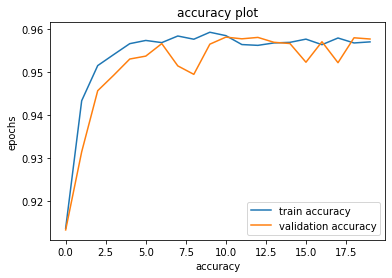

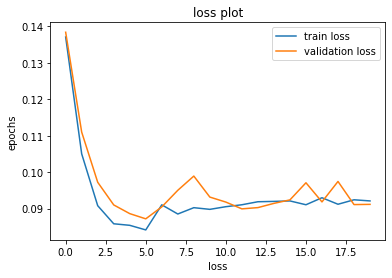

In [1003]:
plt.plot(nn.history['acc'])
plt.plot(nn.history['val_acc'])
plt.title('accuracy plot')
plt.xlabel('accuracy')
plt.ylabel('epochs')
plt.legend(['train accuracy', 'validation accuracy'])
plt.show()

plt.plot(nn.history['loss'])
plt.plot(nn.history['val_loss'])
plt.title('loss plot')
plt.xlabel('loss')
plt.ylabel('epochs')
plt.legend(['train loss', 'validation loss'])
plt.show()

# Making predictions on test dataset



In [1009]:
predictions = nn.predict(testx)

In [1010]:
rowid = testdf.iloc[:, :1].values
rowid.resize(35000,)

In [1011]:
final = pd.DataFrame()
final['Row_ID'] = rowid
final['Outcome1'] = labels[predictions].values
final.to_csv('/content/Predictions.csv', index=False)